In [1]:
import pandas as pd
import numpy as np

# ---------------------------------------------
# 1. LOAD THE DATA
# ---------------------------------------------
# Change your file name here:
df = pd.read_excel(r"E:\IIM Ranchi Course materials\Term II - IIM Ranchi\Data Visualization and Business Intelligence\WAI Project\zara sales analysis\Zara Sales Analysis EXCEL SHEET.xlsx")

print("Data Loaded Successfully!")
print(df.head())

Data Loaded Successfully!
   Product ID Product Position Promotion Product Category Seasonal  \
0      185102            Aisle        No         Clothing       No   
1      188771            Aisle        No         Clothing       No   
2      180176          End-cap       Yes         Clothing      Yes   
3      112917            Aisle       Yes         Clothing      Yes   
4      192936          End-cap        No         Clothing      Yes   

   Sales Volume brand                                                url  \
0          2823  Zara  https://www.zara.com/us/en/basic-puffer-jacket...   
1           654  Zara  https://www.zara.com/us/en/tuxedo-jacket-p0889...   
2          2220  Zara  https://www.zara.com/us/en/slim-fit-suit-jacke...   
3          1568  Zara  https://www.zara.com/us/en/stretch-suit-jacket...   
4          2942  Zara  https://www.zara.com/us/en/double-faced-jacket...   

                sku                  name  \
0   272145190-250-2   BASIC PUFFER JACKET   
1  324

In [2]:
# 2. CLEAN COLUMN NAMES
# ---------------------------------------------
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

print("\nColumns after cleaning:")
print(df.columns)


Columns after cleaning:
Index(['product_id', 'product_position', 'promotion', 'product_category',
       'seasonal', 'sales_volume', 'brand', 'url', 'sku', 'name',
       'description', 'price', 'currency', 'scraped_at', 'terms', 'section'],
      dtype='object')


In [3]:
# 3. HANDLE MISSING VALUES
# ---------------------------------------------
# Replace missing text with empty string ""
text_columns = ["sku", "name", "description", "promotion", "section", "position", "seasonal"]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("")

# Replace missing numbers with 0
numeric_columns = ["price", "sales_volume", "sales", "units", "revenue"]
for col in numeric_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)

In [4]:
# 4. CREATE A SALES COLUMN (if not present)
# ---------------------------------------------
if "sales" not in df.columns:
    if "sales_volume" in df.columns:
        df["sales"] = df["sales_volume"]
    else:
        df["sales"] = 0

In [5]:
# 5. CREATE A REVENUE COLUMN
# ---------------------------------------------
df["revenue"] = df["sales"] * df["price"]

# ---------------------------------------------
# 6. CREATE PROMOTION FLAG (0 / 1)
# ---------------------------------------------
df["promo_flag"] = df["promotion"].str.lower().apply(lambda x: 1 if x == "yes" else 0)


In [6]:
# 7. CREATE SEASONAL FLAG
# ---------------------------------------------
df["seasonal_flag"] = df["seasonal"].str.lower().apply(lambda x: 1 if x == "yes" else 0)

# ---------------------------------------------
# 8. CREATE SIMPLE PRICE BINS
# ---------------------------------------------
df["price_bin"] = pd.cut(
    df["price"],
    bins=[0, 50, 100, 200, 500, 1000],
    labels=["0-50", "50-100", "100-200", "200-500", "500-1000"],
    include_lowest=True
)

In [7]:
# 9. CLEAN DESCRIPTION (very simple cleaning)
# ---------------------------------------------
df["clean_description"] = (
    df["description"]
    .str.lower()
    .str.replace("[^a-zA-Z0-9 ]", "", regex=True)
)

In [8]:
# 10. CREATE TOP SKU TABLE
# ---------------------------------------------
top_skus = (
    df.groupby("sku")
    .agg(total_sales=("sales", "sum"), total_revenue=("revenue", "sum"))
    .reset_index()
    .sort_values("total_sales", ascending=False)
)

In [9]:
# 11. IDENTIFY UNDERPERFORMING SKUs
# ---------------------------------------------
median_sales = top_skus["total_sales"].median()
median_revenue = top_skus["total_revenue"].median()

underperformers = top_skus[
    (top_skus["total_sales"] < median_sales) &
    (top_skus["total_revenue"] < median_revenue)
]

In [11]:
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns

In [12]:
sns.set(style="whitegrid")

In [22]:
price_col = "price"
sales_col = "sales"
revenue_col = "revenue"
promo_col = "promotion"
position_col = "position" if "position" in df.columns else ("product_position" if "product_position" in df.columns else "position")
seasonal_col = "seasonal"
section_col = "section"
pricebin_col = "price_bin"
clean_desc_col = "clean_description"
sku_col = "sku"
name_col = "name"

In [23]:
for c in [price_col, sales_col, revenue_col, promo_col, position_col, seasonal_col, section_col, pricebin_col, clean_desc_col, sku_col, name_col]:
    if c not in df.columns:
        if c in [price_col, sales_col, revenue_col]:
            df[c] = 0
        else:
            df[c] = ""

Plot 1/9 — Category Dominance


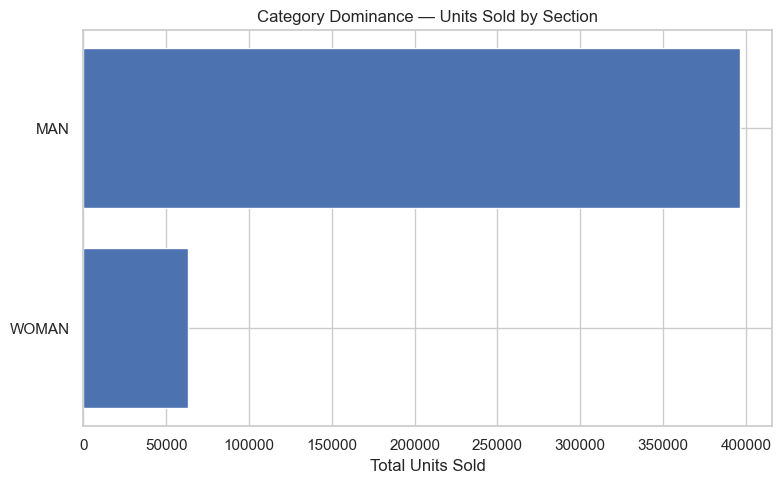

In [24]:
# 1) Category Dominance (by 'section' or fallback to 'category')
print("Plot 1/9 — Category Dominance")
if section_col in df.columns and df[section_col].astype(str).str.strip().any():
    cat = df.groupby(section_col)[sales_col].sum().sort_values()
    plt.figure(figsize=(8,5))
    plt.barh(cat.index.astype(str), cat.values)
    plt.title("Category Dominance — Units Sold by Section")
    plt.xlabel("Total Units Sold")
    plt.tight_layout()
    plt.show()
else:
    print("  Skipped: section/category column not present.")

Plot 2/9 — Placement Matters


C:\Users\milli\AppData\Local\Temp\ipykernel_30800\854284244.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=positions, notch=True)


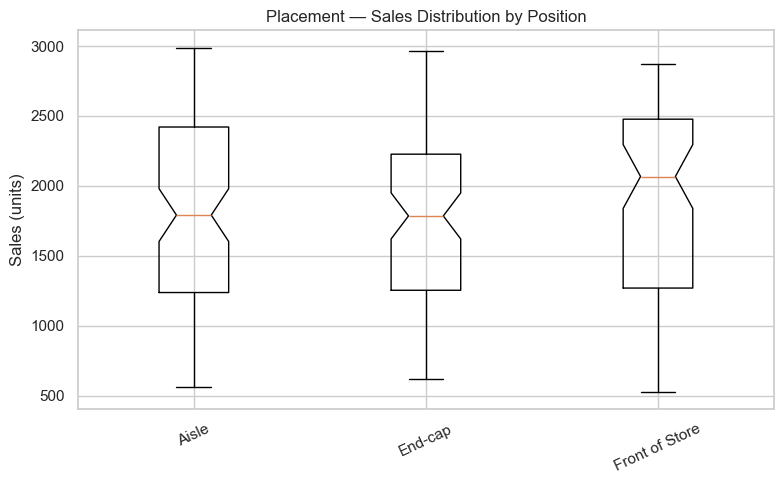

In [25]:
# 2) Placement Matters (boxplot of sales by position)
print("Plot 2/9 — Placement Matters")
positions = df[position_col].fillna("Unknown").astype(str).unique()
groups = [df[df[position_col].astype(str) == p][sales_col].dropna() for p in positions]
plt.figure(figsize=(8,5))
plt.boxplot(groups, labels=positions, notch=True)
plt.ylabel("Sales (units)")
plt.title("Placement — Sales Distribution by Position")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

Plot 3/9 — Promotion Effect


C:\Users\milli\AppData\Local\Temp\ipykernel_30800\3412364004.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([promo_yes, promo_no], labels=["Promotion = Yes", "Promotion = No"], notch=True)


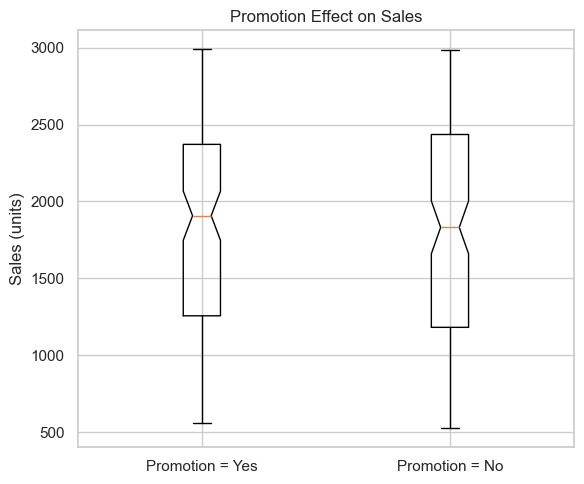

In [26]:
# 3) Promotions Increase Sales Volume (boxplot promo vs non-promo)
print("Plot 3/9 — Promotion Effect")
promo_yes = df[df[promo_col].astype(str).str.lower() == "yes"][sales_col].dropna()
promo_no = df[df[promo_col].astype(str).str.lower() != "yes"][sales_col].dropna()
plt.figure(figsize=(6,5))
plt.boxplot([promo_yes, promo_no], labels=["Promotion = Yes", "Promotion = No"], notch=True)
plt.ylabel("Sales (units)")
plt.title("Promotion Effect on Sales")
plt.tight_layout()
plt.show()

Plot 4/9 — Price Bands & Revenue


C:\Users\milli\AppData\Local\Temp\ipykernel_30800\3998957508.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pb = df.groupby(pricebin_col)[revenue_col].sum().sort_index()


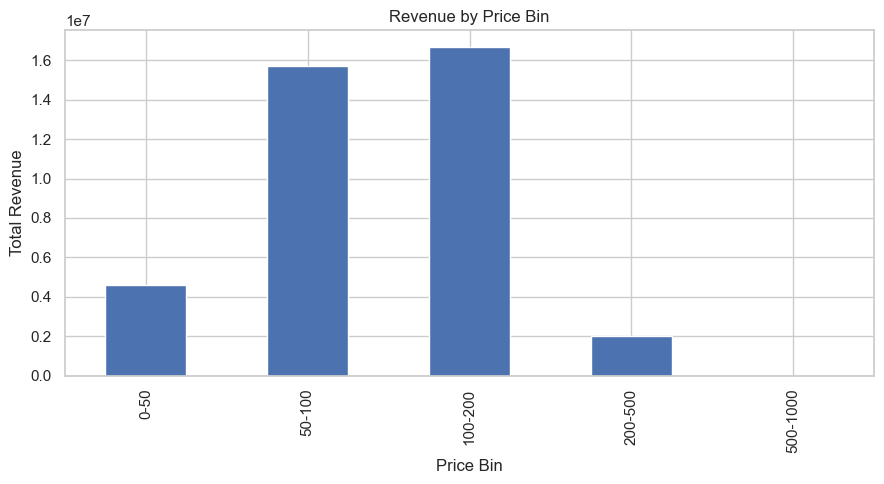

In [27]:
# 4) Price Bands & Revenue (bar chart)
print("Plot 4/9 — Price Bands & Revenue")
# Ensure price_bin exists (preprocessing created it)
if pricebin_col not in df.columns or df[pricebin_col].isnull().all():
    # create a simple fallback bin if missing
    df[pricebin_col] = pd.cut(df[price_col].fillna(-1),
                              bins=[0,50,100,200,500,1000, np.inf],
                              labels=["0-50","50-100","100-200","200-500","500-1000","1000+"],
                              right=False)
pb = df.groupby(pricebin_col)[revenue_col].sum().sort_index()
plt.figure(figsize=(9,5))
pb.plot(kind="bar")
plt.xlabel("Price Bin")
plt.ylabel("Total Revenue")
plt.title("Revenue by Price Bin")
plt.tight_layout()
plt.show()

Plot 5/9 — Seasonal vs Non-Seasonal


C:\Users\milli\AppData\Local\Temp\ipykernel_30800\3877354655.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([season_yes, season_no], labels=["Seasonal = Yes", "Seasonal = No"], notch=True)


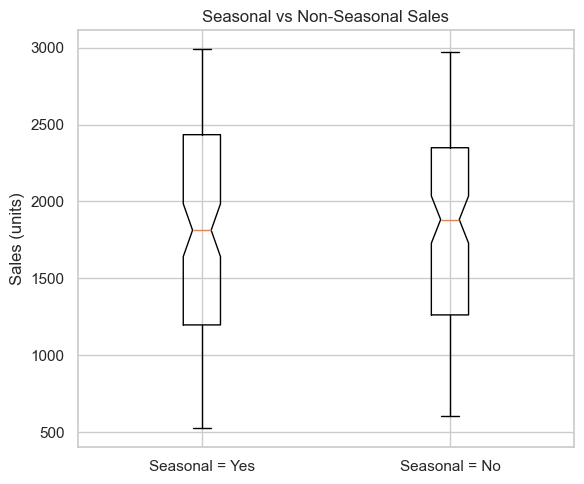

In [28]:
# 5) Seasonal Products (boxplot seasonal vs non-seasonal)
print("Plot 5/9 — Seasonal vs Non-Seasonal")
season_yes = df[df[seasonal_col].astype(str).str.lower() == "yes"][sales_col].dropna()
season_no = df[df[seasonal_col].astype(str).str.lower() != "yes"][sales_col].dropna()
plt.figure(figsize=(6,5))
plt.boxplot([season_yes, season_no], labels=["Seasonal = Yes", "Seasonal = No"], notch=True)
plt.ylabel("Sales (units)")
plt.title("Seasonal vs Non-Seasonal Sales")
plt.tight_layout()
plt.show()

Plot 6/9 — Top SKUs


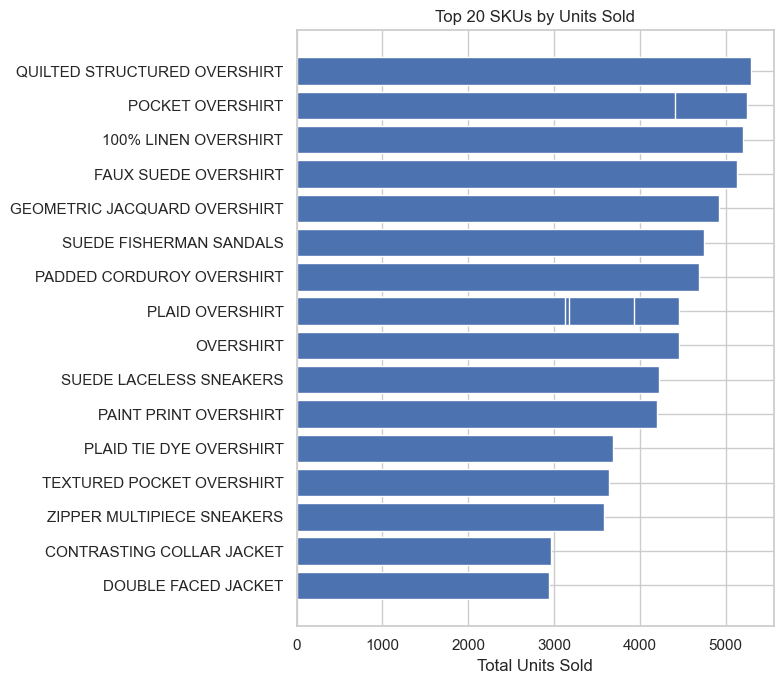

In [29]:
# 6) Top SKUs (bar chart)
print("Plot 6/9 — Top SKUs")
# top_skus created in preprocessing: columns sku, total_sales, total_revenue
if "top_skus" in globals() and not top_skus.empty:
    top20 = top_skus.head(20).copy()
    # Use sku or name for labels if available in original df
    if name_col in df.columns and df[name_col].notna().any():
        sku_to_name = df.drop_duplicates(subset=[sku_col]).set_index(sku_col)[name_col].to_dict()
        top20["label"] = top20["sku"].map(lambda s: sku_to_name.get(s, s))
    else:
        top20["label"] = top20["sku"].astype(str)
    plt.figure(figsize=(8,7))
    plt.barh(top20["label"], top20["total_sales"])
    plt.gca().invert_yaxis()
    plt.xlabel("Total Units Sold")
    plt.title("Top 20 SKUs by Units Sold")
    plt.tight_layout()
    plt.show()
else:
    print("  Skipped: top_skus DataFrame not found.")

Plot 7/9 — Price vs Sales


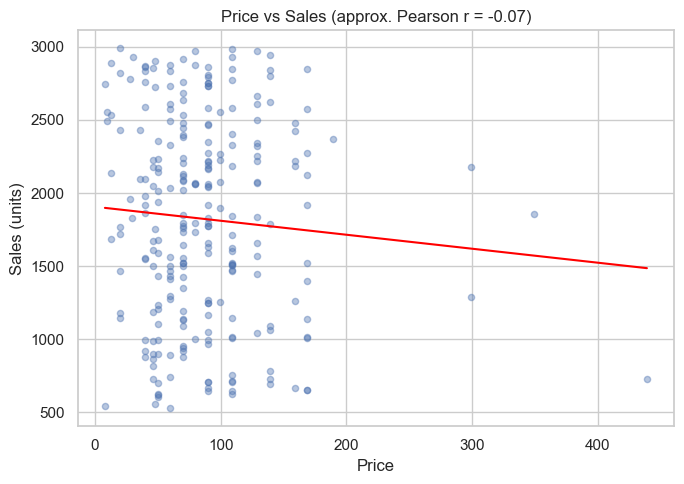

In [30]:
# 7) Price-Sales Relationship (scatter + linear fit)
print("Plot 7/9 — Price vs Sales")
valid = df[[price_col, sales_col]].dropna()
plt.figure(figsize=(7,5))
plt.scatter(valid[price_col], valid[sales_col], alpha=0.4, s=20)
plt.xlabel("Price")
plt.ylabel("Sales (units)")
# linear fit
if len(valid) > 1:
    m, b = np.polyfit(valid[price_col], valid[sales_col], 1)
    xs = np.linspace(valid[price_col].min(), valid[price_col].max(), 100)
    plt.plot(xs, m*xs + b, color="red")
    corr = valid[price_col].corr(valid[sales_col])
    plt.title(f"Price vs Sales (approx. Pearson r = {corr:.2f})")
else:
    plt.title("Price vs Sales")
plt.tight_layout()
plt.show()

Plot 8/9 — Underperformers Quadrant


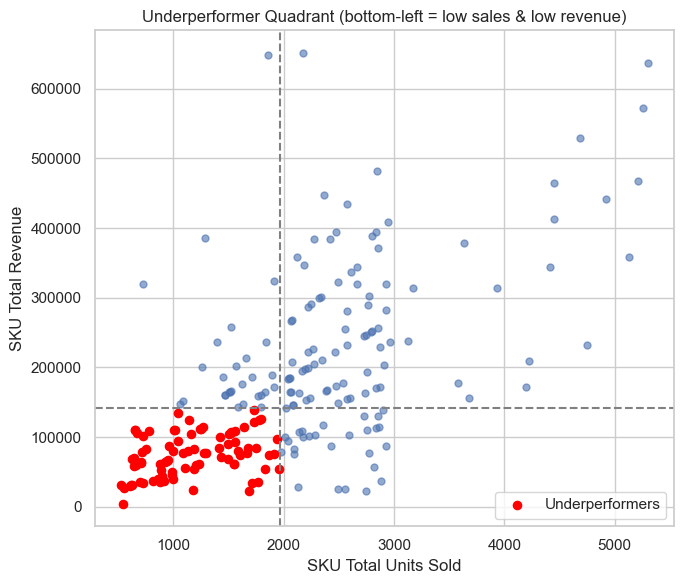

In [31]:
# 8) Underperformers Quadrant (SKU total sales vs total revenue)
print("Plot 8/9 — Underperformers Quadrant")
# use top_skus for SKU-level totals (preprocessing created it)
if "top_skus" in globals() and not top_skus.empty:
    sku_df = top_skus.copy()
    x_med = sku_df["total_sales"].median()
    y_med = sku_df["total_revenue"].median()
    plt.figure(figsize=(7,6))
    plt.scatter(sku_df["total_sales"], sku_df["total_revenue"], alpha=0.6, s=25)
    under = sku_df[(sku_df["total_sales"] < x_med) & (sku_df["total_revenue"] < y_med)]
    plt.scatter(under["total_sales"], under["total_revenue"], color="red", s=35, label="Underperformers")
    plt.axvline(x=x_med, color="gray", linestyle="--")
    plt.axhline(y=y_med, color="gray", linestyle="--")
    plt.xlabel("SKU Total Units Sold")
    plt.ylabel("SKU Total Revenue")
    plt.title("Underperformer Quadrant (bottom-left = low sales & low revenue)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("  Skipped: top_skus DataFrame not found for quadrant plot.")

In [ ]:
# 9) Feature Analysis (word frequency among top SKUs)
print("Plot 9/9 — Feature (Word) Frequency")
# Build word freq from clean_description for SKUs in top 20% by sales
if "top_skus" in globals() and not top_skus.empty:
    cutoff = top_skus["total_sales"].quantile(0.8)
    top_sku_list = top_skus[top_skus["total_sales"] >= cutoff]["sku"].unique()
    texts = df[df[sku_col].isin(top_sku_list)][clean_desc_col].astype(str).tolist()
    wc = Counter()
    stop = set(["the","and","with","for","from","this","that","size","new","product","man","woman","kids"])
    for t in texts:
        tokens = re.sub(r"[^a-z0-9\s]", " ", t.lower()).split()
        tokens = [tok for tok in tokens if len(tok) > 2 and tok not in stop]
        wc.update(tokens)
    common = wc.most_common(20)
    if common:
        words = [w for w,c in common][::-1]
        counts = [c for w,c in common][::-1]
        plt.figure(figsize=(8,6))
        plt.barh(words, counts)
        plt.xlabel("Count")
        plt.title("Top Words in Descriptions of Top-Selling SKUs")
        plt.tight_layout()
        plt.show()
    else:
        print("  No tokens found for feature analysis.")
else:
    print("  Skipped: top_skus DataFrame not found for feature analysis.")

print("All visualization blocks completed.")